## install necessary library and package

In [ ]:
!pip install category_encoders

In [ ]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import itertools
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## **Data Import**

In [ ]:
# Mount drive at first. Then copy the .csv file path to here.
df = pd.read_csv('/content/drive/Shareddrives/CIS520 Final Project/Notebook/Dataset/US_Accidents_Dec20_updated.csv')

In [ ]:
df.head()

,ID,Severity,Start_Time,End_Time,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Description,Number,Street,Side,City,County,State,Zipcode,Country,Timezone,Airport_Code,Weather_Timestamp,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction,Wind_Speed(mph),Precipitation(in),Weather_Condition,Amenity,Bump,Crossing,Give_Way,Junction,No_Exit,Railway,Roundabout,Station,Stop,Traffic_Calming,Traffic_Signal,Turning_Loop,Sunrise_Sunset,Civil_Twilight,Nautical_Twilight,Astronomical_Twilight
0,A-2716600,3,2016-02-08 00:37:08,2016-02-08 06:37:08,40.10891,-83.09286,40.11206,-83.03187,3.230,Between Sawmill Rd/Exit 20 and OH-315/Olentang...,NaN,Outerbelt E,R,Dublin,Franklin,OH,43017,US,US/Eastern,KOSU,2016-02-08 00:53:00,42.1,36.1,58.0,29.76,10.0,SW,10.4,0.00,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
1,A-2716601,2,2016-02-08 05:56:20,2016-02-08 11:56:20,39.86542,-84.06280,39.86501,-84.04873,0.747,At OH-4/OH-235/Exit 41 - Accident.,NaN,I-70 E,R,Dayton,Montgomery,OH,45424,US,US/Eastern,KFFO,2016-02-08 05:58:00,36.9,NaN,91.0,29.68,10.0,Calm,NaN,0.02,Light Rain,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Night,Night
2,A-2716602,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10266,-84.52468,39.10209,-84.52396,0.055,At I-71/US-50/Exit 1 - Accident.,NaN,I-75 S,R,Cincinnati,Hamilton,OH,45203,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
3,A-2716603,2,2016-02-08 06:15:39,2016-02-08 12:15:39,39.10148,-84.52341,39.09841,-84.52241,0.219,At I-71/US-50/Exit 1 - Accident.,NaN,US-50 E,R,Cincinnati,Hamilton,OH,45202,US,US/Eastern,KLUK,2016-02-08 05:53:00,36.0,NaN,97.0,29.70,10.0,Calm,NaN,0.02,Overcast,False,False,False,False,True,False,False,False,False,False,False,False,False,Night,Night,Night,Day
4,A-2716604,2,2016-02-08 06:51:45,2016-02-08 12:51:45,41.06213,-81.53784,41.06217,-81.53547,0.123,At Dart Ave/Exit 21 - Accident.,NaN,I-77 N,R,Akron,Summit,OH,44311,US,US/Eastern,KAKR,2016-02-08 06:54:00,39.0,NaN,55.0,29.65,10.0,Calm,NaN,NaN,Overcast,False,False,False,False,False,False,False,False,False,False,False,False,False,Night,Night,Day,Day


In [ ]:
print('Data shape: ', df.shape)

Data shape:  (1516064, 47)


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1516064 entries, 0 to 1516063
Data columns (total 47 columns):
 #   Column                 Non-Null Count    Dtype  
---  ------                 --------------    -----  
 0   ID                     1516064 non-null  object 
 1   Severity               1516064 non-null  int64  
 2   Start_Time             1516064 non-null  object 
 3   End_Time               1516064 non-null  object 
 4   Start_Lat              1516064 non-null  float64
 5   Start_Lng              1516064 non-null  float64
 6   End_Lat                1516064 non-null  float64
 7   End_Lng                1516064 non-null  float64
 8   Distance(mi)           1516064 non-null  float64
 9   Description            1516064 non-null  object 
 10  Number                 469969 non-null   float64
 11  Street                 1516064 non-null  object 
 12  Side                   1516064 non-null  object 
 13  City                   1515981 non-null  object 
 14  County            

In [ ]:
df.describe()

,Severity,Start_Lat,Start_Lng,End_Lat,End_Lng,Distance(mi),Number,Temperature(F),Wind_Chill(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Speed(mph),Precipitation(in)
count,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,1.516064e+06,4.699690e+05,1.473031e+06,1.066748e+06,1.470555e+06,1.479790e+06,1.471853e+06,1.387202e+06,1.005515e+06
mean,2.238630e+00,3.690056e+01,-9.859919e+01,3.690061e+01,-9.859901e+01,5.872617e-01,8.907533e+03,5.958460e+01,5.510976e+01,6.465960e+01,2.955495e+01,9.131755e+00,7.630812e+00,8.477855e-03
std,6.081481e-01,5.165653e+00,1.849602e+01,5.165629e+00,1.849590e+01,1.632659e+00,2.242190e+04,1.827316e+01,2.112735e+01,2.325986e+01,1.016756e+00,2.889112e+00,5.637364e+00,1.293168e-01
min,1.000000e+00,2.457022e+01,-1.244976e+02,2.457011e+01,-1.244978e+02,0.000000e+00,0.000000e+00,-8.900000e+01,-8.900000e+01,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,2.000000e+00,3.385422e+01,-1.182076e+02,3.385420e+01,-1.182077e+02,0.000000e+00,1.212000e+03,4.700000e+01,4.080000e+01,4.800000e+01,2.944000e+01,1.000000e+01,4.600000e+00,0.000000e+00
50%,2.000000e+00,3.735113e+01,-9.438100e+01,3.735134e+01,-9.437987e+01,1.780000e-01,4.000000e+03,6.100000e+01,5.700000e+01,6.800000e+01,2.988000e+01,1.000000e+01,7.000000e+00,0.000000e+00
75%,2.000000e+00,4.072593e+01,-8.087469e+01,4.072593e+01,-8.087449e+01,5.940000e-01,1.010000e+04,7.300000e+01,7.100000e+01,8.400000e+01,3.004000e+01,1.000000e+01,1.040000e+01,0.000000e+00
max,4.000000e+00,4.900058e+01,-6.711317e+01,4.907500e+01,-6.710924e+01,1.551860e+02,9.999997e+06,1.706000e+02,1.130000e+02,1.000000e+02,5.804000e+01,1.400000e+02,9.840000e+02,2.400000e+01


## Visualize each state accident numbers

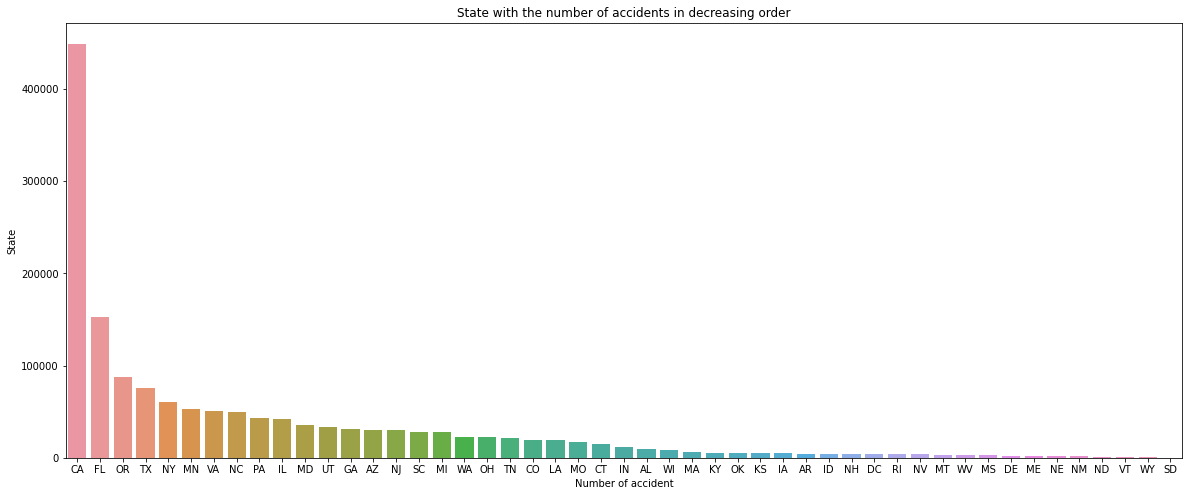

In [ ]:
state_counts = df["State"].value_counts()
plt.figure(figsize=(20, 8))
plt.title("State with the number of accidents in decreasing order")
sns.barplot(x=state_counts.index, y=state_counts.values)
plt.xlabel("Number of accident")
plt.ylabel("State")
plt.show()

## **Feature addition:**

### Add *month, day of week* feature to data

We decided to decompose the Start_Time feature in month and day of week, in order to feed them to the models.

In [ ]:
df["year"]=pd.DatetimeIndex(df["Start_Time"]).year
df["month"]=pd.DatetimeIndex(df["Start_Time"]).month
df["dayofweek"]=pd.DatetimeIndex(df["Start_Time"]).dayofweek

### Visualize accidents vs. year

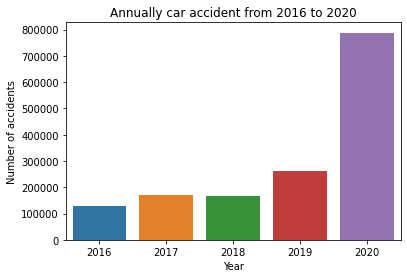

In [ ]:
yearly_accidents=df["year"].value_counts()
plt.title("Annually car accident from 2016 to 2020")
sns.barplot(x=yearly_accidents.index, y=yearly_accidents.values)
plt.xlabel("Year")
plt.ylabel("Number of accidents")
plt.show()

## **Feature selection**

1. Construct a correlation matrix to AID feature selection

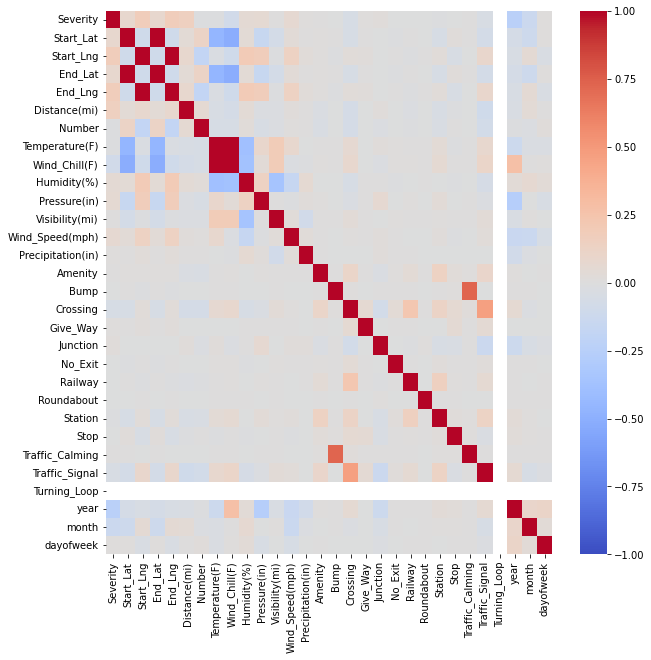

In [ ]:
corelation_matrix = df.corr()
plt.figure(figsize=(10,10))
sns.heatmap(corelation_matrix, vmin=-1, vmax=1, cmap="coolwarm")
plt.show()

## Drop useless features
*Manual:* Features that are of no use for analysis based on intuition analysis

*highly_imbalanced*: Highly imbalanced features that have almost 99% same data

*missing_drop*: Largely missing data

*corr_drop*: Highly correlated features according to correlation matrix result

*interest_drop*: Irrelavant features in our model analysis

In [ ]:
# features does not need
manual = ['ID', 'Description', 'Number', 'Weather_Timestamp', 'Timezone', 'Airport_Code', 'Civil_Twilight', 'Nautical_Twilight', 'Astronomical_Twilight', 'Start_Time','year']
highly_imbalanced = ['Bump', 'Give_Way', 'No_Exit', 'Roundabout', 'Traffic_Calming']
missing_drop = ['Turning_Loop']
corr_drop = ['Wind_Chill(F)', 'End_Time', 'End_Lat', 'End_Lng']
interest_drop = ['Street', 'County', 'City', 'Zipcode', 'Country']

features_to_drop = itertools.chain(manual, highly_imbalanced, missing_drop, corr_drop, interest_drop)
new_df = df.drop(columns=features_to_drop)

## Handle erroneous and impute missing data
1. Drop duplicate data points

2. Drop irrational *Pressure* and *Visibility* data points

3. Drop N/A and null values

4. Interpolate null values in numerical features

In [ ]:
#print(new_df.isnull().sum())

In [ ]:
# Remove duplicate samples
new_df = new_df.drop_duplicates()
# Handle zero value in Pressure(in)	Visibility(mi)
new_df = new_df[new_df['Pressure(in)']!=0] 
new_df = new_df[new_df['Visibility(mi)']!=0] 
# Handle null value in categorical features
new_df = new_df.dropna(subset=['Sunrise_Sunset', 'Weather_Condition', 'Wind_Direction']) # drop categorical values
new_df = new_df[new_df['Side']!=' ']
# Interpolate null value in numerical features
new_df['Temperature(F)'].interpolate(method='linear', inplace=True)
new_df['Humidity(%)'].interpolate(method='linear', inplace=True)
new_df['Pressure(in)'].interpolate(method='linear', inplace=True)
new_df['Visibility(mi)'].interpolate(method='linear', inplace=True)
new_df['Wind_Speed(mph)'].interpolate(method='linear', inplace=True)
new_df['Precipitation(in)'].interpolate(method='linear', inplace=True)

# Status Monitoring
# print(new_df.isnull().sum())
# new_df.describe()

## Handle unbalanced data
Since the amount of severity data differs significatnly, we will undersample data to keep all four severity data amoung to be the same. Since the minimum number of data is severity 1 level with around 25k, the data after undersampling should still make much sense.

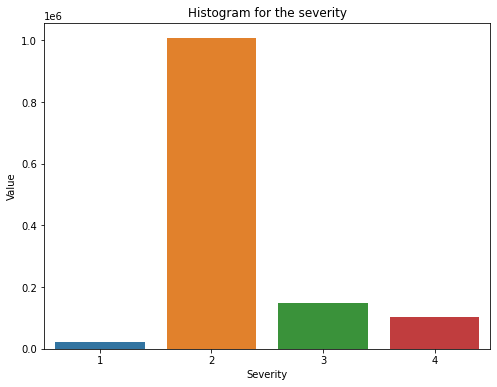

In [ ]:
severity_counts = new_df["Severity"].value_counts()

plt.figure(figsize=(8, 6))
plt.title("Histogram for the severity")
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

In [ ]:
min_size = len(new_df[new_df["Severity"]==1])
df = pd.DataFrame()
for i in range(1,5):
    S = new_df[new_df["Severity"]==i]
    df = df.append(S.sample(min_size, random_state=42))
new_df = df

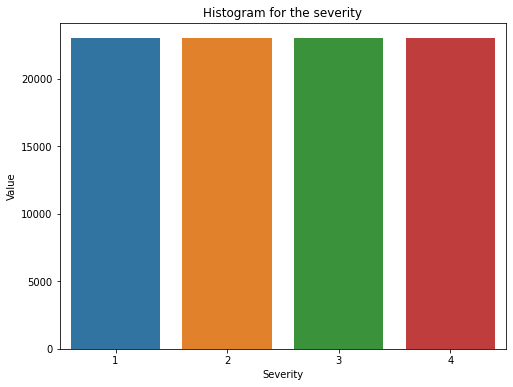

In [ ]:
severity_counts = new_df["Severity"].value_counts()

plt.figure(figsize=(8, 6))
plt.title("Histogram for the severity")
sns.barplot(x=severity_counts.index, y=severity_counts.values)
plt.xlabel("Severity")
plt.ylabel("Value")
plt.show()

## Feature scaling
In order to feed data to all models without further processing, we decide to scale all numerical features so scale-variant model can directly use it

In [ ]:
scaler = MinMaxScaler()
features = ['Temperature(F)','Distance(mi)','Humidity(%)','Pressure(in)','Visibility(mi)','Wind_Speed(mph)','Precipitation(in)', 'month','dayofweek','Start_Lat', 'Start_Lng']
new_df[features] = scaler.fit_transform(new_df[features])
# new_df.head()

## Encoding Categorical Data
Object data includes: Start_Time*, Side, State, Wind_Direction, Weather_Condition, Sunrise_Sunset.

We need to encode them into binary representation so that it can be feed into model for analysis

In [ ]:
#new_df.dtypes
'''
Input: DataFrame
Output: Encoded Data, df_encoder(used to encode data)
'''
df_encoder = ce.BinaryEncoder(cols=['Side','State','Wind_Direction','Weather_Condition','Sunrise_Sunset'], return_df=True)
new_df=df_encoder.fit_transform(new_df)

#print(data_encoded.info)
#print(df_encoder.get_feature_names())
#data_decoded=df_encoder.inverse_transform(data_encoded)
#print(data_decoded)

### Change four severity levels into two levels for easier analysis and more direct result

In [ ]:
binary_dataset = new_df.copy()
binary_dataset.loc[ (new_df['Severity'] <= 2), 'Severity']=0
binary_dataset.loc[ (new_df['Severity'] > 2), 'Severity']=1

In [ ]:
binary_dataset.head()

,Severity,Start_Lat,Start_Lng,Distance(mi),Side_0,Side_1,State_0,State_1,State_2,State_3,State_4,State_5,Temperature(F),Humidity(%),Pressure(in),Visibility(mi),Wind_Direction_0,Wind_Direction_1,Wind_Direction_2,Wind_Direction_3,Wind_Direction_4,Wind_Speed(mph),Precipitation(in),Weather_Condition_0,Weather_Condition_1,Weather_Condition_2,Weather_Condition_3,Weather_Condition_4,Weather_Condition_5,Weather_Condition_6,Amenity,Crossing,Junction,Railway,Station,Stop,Traffic_Signal,Sunrise_Sunset_0,Sunrise_Sunset_1,month,dayofweek
769043,0,0.440559,0.777642,0.000000,0,1,0,0,0,0,0,1,0.671233,0.602041,0.248885,0.09946,0,0,0,0,1,0.012717,0.000000,0,0,0,0,0,0,1,False,True,False,False,False,False,True,0,1,0.363636,0.500000
945439,0,0.696287,0.647161,0.000000,0,1,0,0,0,0,1,0,0.527397,0.908163,0.238919,0.09946,0,0,0,1,0,0.021195,0.002987,0,0,0,0,0,1,0,False,False,False,False,False,False,False,1,0,0.272727,0.333333
755750,0,0.311659,0.240831,0.000000,1,0,0,0,0,0,1,1,0.883562,0.030612,0.186730,0.09946,0,0,0,1,1,0.031793,0.000000,0,0,0,0,0,0,1,False,True,False,False,False,False,True,1,0,0.363636,0.500000
758722,0,0.571167,0.047943,0.000064,0,1,0,0,0,1,0,0,0.726027,0.346939,0.260163,0.09946,0,0,1,0,0,0.012717,0.000000,0,0,0,0,0,0,1,False,False,False,False,False,False,False,1,0,0.363636,0.666667
866136,0,0.136250,0.745744,0.020563,0,1,0,0,0,1,0,1,0.726027,0.704082,0.272751,0.09946,0,0,1,0,1,0.016956,0.000000,0,0,0,0,0,0,1,False,False,False,False,False,False,False,1,0,0.181818,0.666667


### Output modified dataset to be used in later model training

In [ ]:
binary_dataset.to_csv('/content/drive/Shareddrives/CIS520 Final Project/Notebook/Dataset/binary_dataset_noYear.csv')